In [2]:
import Orange
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import numpy as np
import math

In [3]:
#Results as comma separated values, rows are datasets, columns are algorithms to compare, first row is algorithm names
ex_acc = pd.read_csv('./Results/ex_acc.csv', index_col=False).to_numpy()
hamming = pd.read_csv('./Results/hamming.csv', index_col=False).to_numpy()
f1_ex = pd.read_csv('./Results/f1_ex.csv', index_col=False).to_numpy()
f1_mic = pd.read_csv('./Results/f1_mic.csv', index_col=False).to_numpy()
f1_mac = pd.read_csv('./Results/f1_mac.csv', index_col=False).to_numpy()
results = [ex_acc, hamming, f1_ex, f1_mic,f1_mac]

In [4]:
names = ['LD3','ADWIN','EDDM','DDM','KSWIN','HDDM_A','HDDM_W','FHDDM','FHDDMS','FHDDMS_Add','MDDM_A','MDDM_E','MDDM_G','SeqDrift2','RDDM','ND']
plot_names=['nemenyi_acc', 'nemenyi_hamming', 'nemenyi_f1ex', 'nemenyi_f1mic', 'nemenyi_f1mac']

In [5]:
def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    if cd and cdmethod is None:
        # get pairs of non significant methods

        def get_lines(sums, hsd):
            # get all pairs
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if j > i]
            # remove not significant
            notSig = [(i, j) for i, j in allpairs
                      if abs(sums[i] - sums[j]) <= hsd]
            # keep only longest

            def no_longer(ij_tuple, notSig):
                i, j = ij_tuple
                for i1, j1 in notSig:
                    if (i1 <= i and j1 > j) or (i1 < i and j1 >= j):
                        return False
                return True

            longest = [(i, j) for i, j in notSig if no_longer((i, j), notSig)]

            return longest

        lines = get_lines(ssums, cd)
        linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1

        # add scale
        distanceh = 0.25
        cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]


    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, color='k', *args, **kwargs):
        ax.text(wf * x, hf * y, s, color=color, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7, color='k')

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7, color='k')

    # Numbers over the line
    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", color='b')

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=0.7, color='k')
        text(textspace - 0.2, chei, '{} ({})'.format(nnames[i], np.round(ssums[i],decimals=2)), ha="right", va="center", color='k')

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=0.7, color='k')
        text(textspace + scalewidth + 0.2, chei, '{} ({})'.format(nnames[i], np.round(ssums[i],decimals=2)),
             ha="left", va="center", color='k')

    if cd and cdmethod is None:
        # upper scale
        if not reverse:
            begin, end = rankpos(lowv), rankpos(lowv + cd)
        else:
            begin, end = rankpos(highv), rankpos(highv - cd)

        # CD Line
        line([(begin, distanceh), (end, distanceh)], linewidth=0.7, color='r')
        line([(begin, distanceh + bigtick / 2),
              (begin, distanceh - bigtick / 2)],
             linewidth=0.7, color='r')
        line([(end, distanceh + bigtick / 2),
              (end, distanceh - bigtick / 2)],
             linewidth=0.7, color='r')
        text((begin + end) / 2, distanceh - 0.05, "CD = {}".format(np.round(cd, decimals=4)), color='r',
             ha="center", va="bottom")

        # no-significance lines
        def draw_lines(lines, side=0.05, height=0.1):
            start = cline + 0.2
            for l, r in lines:
                line([(rankpos(ssums[l]) - side, start),
                      (rankpos(ssums[r]) + side, start)],
                     linewidth=2.5, color='r')
                start += height

        draw_lines(lines)

    elif cd:
        begin = rankpos(avranks[cdmethod] - cd)
        end = rankpos(avranks[cdmethod] + cd)
        line([(begin, cline), (end, cline)],
             linewidth=2.5)
        line([(begin, cline + bigtick / 2),
              (begin, cline - bigtick / 2)],
             linewidth=2.5)
        line([(end, cline + bigtick / 2),
              (end, cline - bigtick / 2)],
             linewidth=2.5)

    if filename:
        print_figure(fig, filename, **kwargs)

cd= 6.659026753589229
[ 1.          8.45833333  6.25       10.58333333  8.66666667  8.08333333
  9.79166667  9.83333333 10.41666667  9.95833333 10.25       10.
 10.          9.25        5.375       8.08333333]


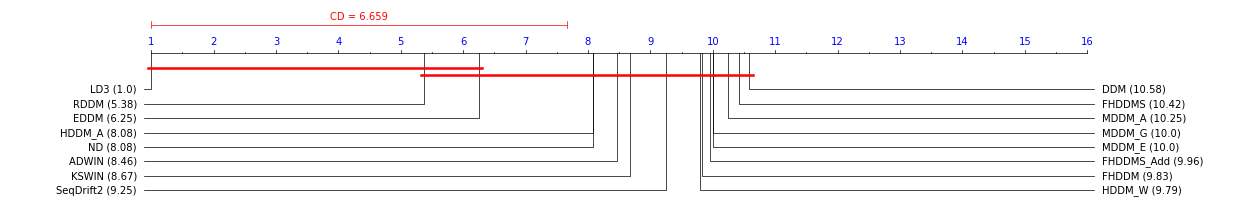

cd= 6.659026753589229
[ 1.5         6.66666667  8.         10.16666667  9.45833333  9.375
 10.58333333  9.20833333  9.66666667 10.54166667  9.66666667  9.29166667
  9.20833333  8.83333333  4.58333333  9.25      ]


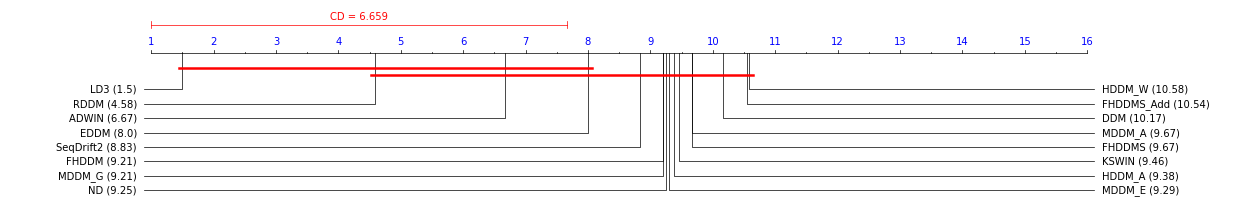

cd= 6.659026753589229
[ 2.75        7.45833333  8.16666667 12.08333333  8.95833333  6.45833333
  8.75       10.375      10.25        9.29166667  9.79166667  9.625
  9.625       8.20833333  6.54166667  7.66666667]


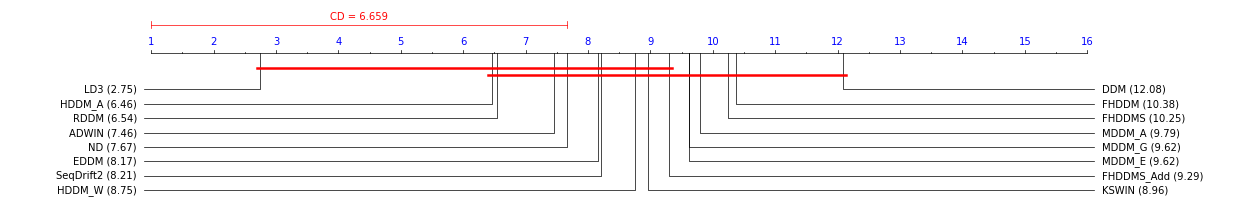

cd= 6.659026753589229
[ 1.          8.41666667  6.25       10.58333333  8.70833333  8.125
  9.75        9.91666667 10.29166667  9.95833333 10.375      10.08333333
  9.875       9.25        5.33333333  8.08333333]


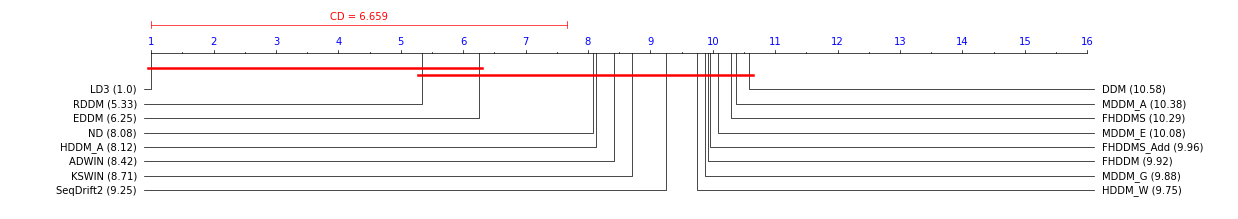

cd= 6.659026753589229
[ 4.66666667  9.75        8.95833333 10.625       7.54166667  6.91666667
  8.125       8.875       9.58333333  9.45833333  9.66666667  9.375
  9.25        7.95833333  7.58333333  7.66666667]


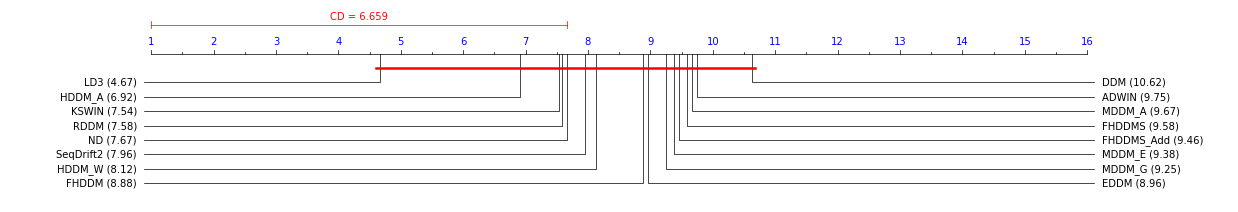

In [11]:
for i, result in enumerate(results):
    av_ranks = np.zeros((16,)) # Enter number of algorithms
    for j in range(len(result)):
        if i == 1:
            vals = result[j]
        else:
            vals = result[j] * -1
        ranks = scipy.stats.rankdata(vals, method='average')
        av_ranks += ranks
    av_ranks *= 1/len(result)
    cd = Orange.evaluation.compute_CD(av_ranks, 12) # Number of tests/datasets
    print('cd=',cd)
    print(av_ranks)
    #Orange.evaluation.graph_ranks(av_ranks, names, cd=cd, width=15, textspace=2, cd_method=0)
    graph_ranks(av_ranks, names, cd=cd, width=15, textspace=2, cd_method=0)
    plt.savefig('./Results/{}.png'.format(plot_names[i]), dpi=600) # plt.savefig('./Results/{}.eps'.format(plot_names[i])) 
    plt.show()
    plt.close()
    

In [ ]:
import numpy as np
from numpy.core.numeric import correlate
from numpy.random import sample
import util
from scipy import stats
from river.base import DriftDetector
from scipy.spatial import distance
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import time
from skmultiflow.data import DataStream, MultilabelGenerator, ConceptDriftStream

class StreamGenerator():
    def __init__(self):
        pass

    def get_stream(self, type):
        sample_size = 0
        stream = None
        n_features = 0
        n_targets = 0
        if type == 'sudden1':
            n_features = 200
            n_targets = 50
            s1 = MultilabelGenerator(n_samples=6000, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=100) 
            s2 = MultilabelGenerator(n_samples=6009, n_features=n_features, n_targets=n_targets, n_labels=4, random_state=250)
            s3 = MultilabelGenerator(n_samples=10009, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=0)
            stream1 = ConceptDriftStream(stream=s1, drift_stream=s2, position=4000, width=25, random_state=0)
            stream = ConceptDriftStream(stream=stream1, drift_stream=s3, position=10000, width=25, random_state=0)
            sample_size=20000
        elif type == 'gradual1':
            n_features = 200
            n_targets = 50
            s1 = MultilabelGenerator(n_samples=6000, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=100) 
            s2 = MultilabelGenerator(n_samples=6500, n_features=n_features, n_targets=n_targets, n_labels=4, random_state=250)
            s3 = MultilabelGenerator(n_samples=15500, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=0)
            stream1 = ConceptDriftStream(stream=s1, drift_stream=s2, position=4000, width=250, random_state=0)
            stream = ConceptDriftStream(stream=stream1, drift_stream=s3, position=10000, width=250, random_state=0)
            sample_size=20000
        elif type == 'sudden2':
            n_features = 200
            n_targets = 50
            s1 = MultilabelGenerator(n_samples=6000, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=100) 
            s2 = MultilabelGenerator(n_samples=6009, n_features=n_features, n_targets=n_targets, n_labels=4, random_state=250)
            s3 = MultilabelGenerator(n_samples=10009, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=0)
            stream1 = ConceptDriftStream(stream=s1, drift_stream=s2, position=4000, width=1, random_state=0)
            stream = ConceptDriftStream(stream=stream1, drift_stream=s3, position=10000, width=1, random_state=0)
            sample_size=20000
        elif type == 'sudden3':
            n_features = 200
            n_targets = 50
            s1 = MultilabelGenerator(n_samples=6000, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=100) 
            s2 = MultilabelGenerator(n_samples=6009, n_features=n_features, n_targets=n_targets, n_labels=4, random_state=250)
            s3 = MultilabelGenerator(n_samples=10009, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=0)
            stream1 = ConceptDriftStream(stream=s1, drift_stream=s2, position=4000, width=50, random_state=0)
            stream = ConceptDriftStream(stream=stream1, drift_stream=s3, position=10000, width=50, random_state=0)
            sample_size=20000
        elif type == 'mixed':
            n_features = 100
            n_targets = 50
            s1 = MultilabelGenerator(n_samples=25000, n_features=n_features, n_targets=n_targets, n_labels=1, random_state=100) 
            s2 = MultilabelGenerator(n_samples=25009, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=250)
            s3 = MultilabelGenerator(n_samples=25015, n_features=n_features, n_targets=n_targets, n_labels=3, random_state=0)
            s4 = MultilabelGenerator(n_samples=25015, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=100)
            s5 = MultilabelGenerator(n_samples=25009, n_features=n_features, n_targets=n_targets, n_labels=1, random_state=250)
            stream1 = ConceptDriftStream(stream=s1, drift_stream=s2, position=20000, width=1, random_state=0)
            stream2 = ConceptDriftStream(stream=stream1, drift_stream=s3, position=40000, width=100, random_state=0)
            stream3 = ConceptDriftStream(stream=stream2, drift_stream=s4, position=60000, width=100, random_state=0)
            stream = ConceptDriftStream(stream=stream3, drift_stream=s5, position=80000, width=1, random_state=0)
            sample_size=100000
        elif type == 'gradual2':
            n_features = 200
            n_targets = 50
            s1 = MultilabelGenerator(n_samples=6000, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=100) 
            s2 = MultilabelGenerator(n_samples=6500, n_features=n_features, n_targets=n_targets, n_labels=4, random_state=250)
            s3 = MultilabelGenerator(n_samples=15500, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=0)
            stream1 = ConceptDriftStream(stream=s1, drift_stream=s2, position=4000, width=500, random_state=0)
            stream = ConceptDriftStream(stream=stream1, drift_stream=s3, position=10000, width=500, random_state=0)
            sample_size=20000
        elif type == 'gradual3':
            n_features = 200
            n_targets = 50
            s1 = MultilabelGenerator(n_samples=6000, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=100) 
            s2 = MultilabelGenerator(n_samples=6500, n_features=n_features, n_targets=n_targets, n_labels=4, random_state=250)
            s3 = MultilabelGenerator(n_samples=15500, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=0)
            stream1 = ConceptDriftStream(stream=s1, drift_stream=s2, position=4000, width=1000, random_state=0)
            stream = ConceptDriftStream(stream=stream1, drift_stream=s3, position=10000, width=1000, random_state=0)
            sample_size=20000
        elif type == 'reoccurring':
            n_features = 200
            n_targets = 50
            s1 = MultilabelGenerator(n_samples=6000, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=0) 
            s2 = MultilabelGenerator(n_samples=6500, n_features=n_features, n_targets=n_targets, n_labels=4, random_state=250)
            s3 = MultilabelGenerator(n_samples=15500, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=0)
            stream1 = ConceptDriftStream(stream=s1, drift_stream=s2, position=4000, width=500, random_state=0)
            stream = ConceptDriftStream(stream=stream1, drift_stream=s3, position=10000, width=500, random_state=0)
            sample_size=20000
        elif type == 'benchmark1':
            n_features = 100
            n_targets = 20
            s1 = MultilabelGenerator(n_samples=6000, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=100) 
            s2 = MultilabelGenerator(n_samples=6009, n_features=n_features, n_targets=n_targets, n_labels=4, random_state=250)
            s3 = MultilabelGenerator(n_samples=10009, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=0)
            stream1 = ConceptDriftStream(stream=s1, drift_stream=s2, position=4000, width=1, random_state=0)
            stream = ConceptDriftStream(stream=stream1, drift_stream=s3, position=10000, width=1, random_state=0)
            sample_size=20000
        elif type == 'benchmark2':
            n_features = 100
            n_targets = 50
            s1 = MultilabelGenerator(n_samples=6000, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=100) 
            s2 = MultilabelGenerator(n_samples=6009, n_features=n_features, n_targets=n_targets, n_labels=4, random_state=250)
            s3 = MultilabelGenerator(n_samples=10009, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=0)
            stream1 = ConceptDriftStream(stream=s1, drift_stream=s2, position=4000, width=1, random_state=0)
            stream = ConceptDriftStream(stream=stream1, drift_stream=s3, position=10000, width=1, random_state=0)
            sample_size=20000
        elif type == 'benchmark3':
            n_features = 100
            n_targets = 100
            s1 = MultilabelGenerator(n_samples=6000, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=100) 
            s2 = MultilabelGenerator(n_samples=6009, n_features=n_features, n_targets=n_targets, n_labels=4, random_state=250)
            s3 = MultilabelGenerator(n_samples=10009, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=0)
            stream1 = ConceptDriftStream(stream=s1, drift_stream=s2, position=4000, width=1, random_state=0)
            stream = ConceptDriftStream(stream=stream1, drift_stream=s3, position=10000, width=1, random_state=0)
            sample_size=20000
        return stream, sample_size, n_features, n_targets
